<div align="center">

# Customer Segmentation & Retention Analysis (RFM Model)
### Data Cleaning • Exploration • Segmentation • Insights

</div>

# 02_RFM Feature Engineering
**Goal:** Derive Recency, Frequency, and Monetary features for each customer to prepare for RFM scoring and segmentation.

---

## 📂 Work Structure
We’ll follow these structured steps, similar to previous phases:
1. Notebook Setup  
2. Reference Date Setup  
3. RFM Feature Calculation  
4. Outlier & Edge Case Handling  
5. Exploratory Checks  
6. Export & Summary

---

## Step 1 — Notebook Setup

We begin by importing required libraries and loading the cleaned dataset generated in Phase B.

We’ll check the shape, columns, and first few rows to confirm data readiness for feature engineering.


In [1]:
# Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Setting pandas display options for better visibility
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Load the cleaned dataset (from Phase B)
df = pd.read_csv(r"C:\Users\AZAN LAPTOP STORE\Downloads\Portfolio\Projects\Customer Segmentation & Retention Analysis (RFM Model)\data\online_retail_cleaned.csv")

# Basic info
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# Preview first few rows
df.head()


Shape: (333234, 10)
Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country', 'TotalPrice', 'InvoiceWeek']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceWeek
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,15.30,2010-11-29
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-11-29
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,22.00,2010-11-29
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-11-29
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-11-29


## Step 2 — Reference Date Setup

RFM requires a *reference date* — typically one day after the last recorded transaction.

- **Recency** will be calculated as: days since last purchase (`reference_date - last_purchase_date`).
- This helps us understand how recently each customer bought something.


In [2]:
# Convert InvoiceDate column to datetime (if not already)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Define reference date: one day after last transaction date
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Reference Date:", reference_date)


Reference Date: 2011-12-10 12:50:00


## Step 3 — RFM Feature Calculation

We now group transactions by **CustomerID** and calculate:
- **Recency:** Days since last purchase
- **Frequency:** Number of unique invoices
- **Monetary:** Total amount spent

This step converts transactional data into customer-level summaries.


In [3]:
# Group by CustomerID to calculate R, F, M
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

# Rename columns for clarity
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Preview first few records
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12347.00,2,7,3314.73
1,12348.00,249,3,90.20
2,12349.00,19,1,999.15
3,12350.00,310,1,294.40
4,12352.00,36,7,1130.94


## Step 4 — Handle Outliers & Edge Cases

After computing RFM metrics, we ensure no invalid or zero-value customers remain.

- Remove records with **Monetary ≤ 0** or **Frequency = 0**.
- This ensures meaningful RFM interpretation.


In [4]:
# Count invalid cases before filtering
invalid_count = rfm[(rfm['Monetary'] <= 0) | (rfm['Frequency'] <= 0)].shape[0]
print(f"Invalid customer entries (to remove): {invalid_count}")

# Filter out invalid rows
rfm = rfm[(rfm['Monetary'] > 0) & (rfm['Frequency'] > 0)].copy()

# Check result
rfm.shape


Invalid customer entries (to remove): 0


(4191, 4)

## Step 5 — Exploratory Checks

We’ll review RFM summary statistics and visualize their distributions.

This helps identify data ranges and skewness before scoring.


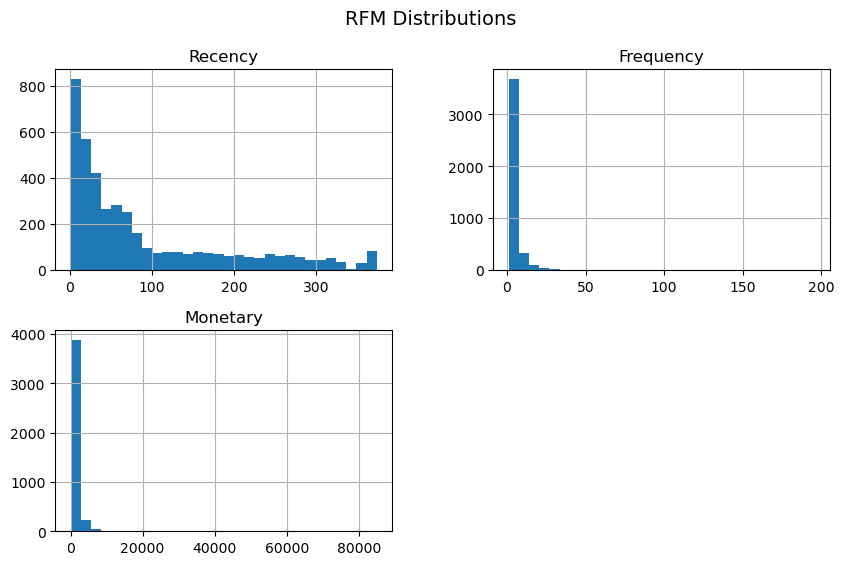

In [6]:
# Summary statistics
rfm.describe().T
# Simple histograms for each metric
rfm[['Recency', 'Frequency', 'Monetary']].hist(bins=30, figsize=(10, 6))
plt.suptitle('RFM Distributions', fontsize=14)
plt.show()

## Step 6 — RFM Scoring & Final Export

Now that we’ve calculated raw Recency, Frequency, and Monetary metrics,  
we’ll convert them into **standardized 1–5 scores** for segmentation purposes.

**Why Scoring?**  
R, F, M values have very different scales (e.g., days vs money vs counts).  
To compare customers fairly, we use **quantile-based scoring**:
- Lower *Recency* → better (recent buyers) → higher score  
- Higher *Frequency* and *Monetary* → better → higher score  

We’ll also:
- Add a log-transformed version of Monetary to handle skewed values.
- Concatenate scores into one combined `RFM_score` string.
- Document the reference date for reproducibility.


In [8]:
# Log-transform Monetary to reduce skewness
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])

# Assign quantile-based scores (1–5)
# Lower Recency = better, so we reverse the order for R
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)

# Higher Frequency and Monetary = better
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Combine into overall RFM string score (e.g., "543")
rfm['RFM_score'] = (
    rfm['R_score'].astype(str)
    + rfm['F_score'].astype(str)
    + rfm['M_score'].astype(str)
)

# Quick distribution check
print("R Score Distribution:\n", rfm['R_score'].value_counts().sort_index(), "\n")
print("F Score Distribution:\n", rfm['F_score'].value_counts().sort_index(), "\n")
print("M Score Distribution:\n", rfm['M_score'].value_counts().sort_index(), "\n")

# Save final scored dataset
rfm.to_csv(r"C:\Users\AZAN LAPTOP STORE\Downloads\Portfolio\Projects\Customer Segmentation & Retention Analysis (RFM Model)\data\customer_rfm.csv")
print("Final RFM file saved: customer_rfm.csv")



R Score Distribution:
 R_score
1    836
2    823
3    825
4    863
5    844
Name: count, dtype: int64 

F Score Distribution:
 F_score
1    839
2    838
3    838
4    838
5    838
Name: count, dtype: int64 

M Score Distribution:
 M_score
1    839
2    838
3    838
4    838
5    838
Name: count, dtype: int64 

Final RFM file saved: customer_rfm.csv


### 📘 Documentation & Notes

**Reference Date:**  
`{{ reference_date }}` (the date one day after the last invoice)  
Keep this constant for reproducibility — future runs should use the same reference date to ensure comparable RFM values.

**Tie & Edge Handling:**  
- Used `rank(method='first')` for Frequency to avoid quantile-tie errors.  
- Quantile bins evenly distribute customers into 5 segments per metric.

**Files Created:**  
- `customer_rfm.csv` → Final customer-level RFM + scores  

---

### Summary

| Step | Task | Output |
|------|------|---------|
| 1–3 | Compute R, F, M | `rfm_features` |
| 4 | Handle outliers | Clean RFM table |
| 5 | Explore distributions | Histograms, summary |
| 6 | Score & finalize | `customer_rfm.csv` |

**Next Phase →** Segmentation mapping & labels (Notebook 03)